In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.tensorflow.data import _parse_function

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

# the nightly build of tensorflow_probability is required as of the time of writing this 
import tensorflow_probability as tfp
ds = tfp.distributions

In [5]:
print(tf.__version__, tfp.__version__, tf.__file__)

2.0.0-beta1 0.7.0-dev20190510 /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/__init__.py


In [6]:
TRAIN_SIZE=482608
BATCH_SIZE=64
TEST_SIZE=10000
DIMS = (128, 128, 1)
N_TRAIN_BATCHES =int((TRAIN_SIZE-TEST_SIZE)/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_SIZE/BATCH_SIZE)
TRAIN_BUF = 1000
TEST_BUF = 1000

In [7]:
network_type = 'GAIA'

In [8]:
DATASET_ID = 'european_starling_gentner_segmented'

In [9]:
record_loc = DATA_DIR / 'tfrecords' / "starling.tfrecords"

In [10]:
# read the dataset
raw_dataset = tf.data.TFRecordDataset([record_loc.as_posix()])

In [11]:
data_types = {
    "spectrogram": tf.uint8,
    "index": tf.int64,
    "indv": tf.string,
}

In [12]:
# parse each data type to the raw dataset
dataset = raw_dataset.map(lambda x: _parse_function(x, data_types=data_types))

In [13]:
spec, index, indv  = next(iter(dataset))

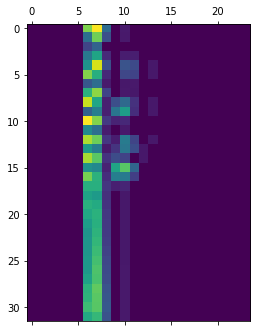

In [14]:
plt.matshow(spec.numpy().reshape(DIMS).squeeze())

In [15]:
test_dataset = dataset.take(TEST_SIZE).shuffle(TEST_BUF).batch(BATCH_SIZE)
train_dataset = dataset.skip(TEST_SIZE).take(TRAIN_SIZE-TEST_SIZE).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [16]:
N_Z = 128

def unet_convblock_down(
    _input,
    channels=16,
    kernel=(3, 3),
    activation=tf.nn.leaky_relu,
    pool_size=(2, 2),
    kernel_initializer="he_normal",
):
    """ An upsampling convolutional block for a UNET
    """
    conv = tf.keras.layers.Conv2D(
        channels,
        kernel,
        activation=activation,
        padding="same",
        kernel_initializer=kernel_initializer,
    )(_input)
    conv = tf.keras.layers.Conv2D(
        channels,
        kernel,
        activation=activation,
        padding="same",
        kernel_initializer=kernel_initializer,
    )(conv)
    pool = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(conv)
    return conv, pool


def unet_convblock_up(
    last_conv,
    cross_conv,
    channels=16,
    kernel=(3, 3),
    activation=tf.nn.leaky_relu,
    pool_size=(2, 2),
    kernel_initializer="he_normal",
):
    """ A downsampling convolutional block for a UNET
    """

    up_conv = tf.keras.layers.UpSampling2D(size=(2, 2))(last_conv)
    merge = tf.keras.layers.concatenate([up_conv, cross_conv], axis=3)
    conv = tf.keras.layers.Conv2D(
        channels,
        kernel,
        activation=activation,
        padding="same",
        kernel_initializer=kernel_initializer,
    )(merge)
    conv = tf.keras.layers.Conv2D(
        channels,
        kernel,
        activation=activation,
        padding="same",
        kernel_initializer=kernel_initializer,
    )(conv)
    return conv


def unet_canary():
    """ the architecture for a UNET specific to MNIST
    """
    inputs = tf.keras.layers.Input(shape=(32, 24, 1))
    up_1, pool_1 = unet_convblock_down(inputs, channels=16)
    up_2, pool_2 = unet_convblock_down(pool_1, channels=32)
    up_3, pool_3 = unet_convblock_down(pool_2, channels=64)
    up_4, pool_4 = unet_convblock_down(pool_3, channels=128)
    conv_middle = tf.keras.layers.Conv2D(
        128, (3, 3), activation=tf.nn.leaky_relu, kernel_initializer="he_normal", padding="same"
    )(pool_4)
    conv_middle = tf.keras.layers.Conv2D(
        128, (3, 3), activation=tf.nn.leaky_relu, kernel_initializer="he_normal", padding="same"
    )(conv_middle)
    down_4 = unet_convblock_up(conv_middle, up_4, channels=128)
    down_3 = unet_convblock_up(down_4, up_3, channels=64)
    down_2 = unet_convblock_up(down_3, up_2, channels=32)
    down_1 = unet_convblock_up(down_2, up_1, channels=16)
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation="tanh")(down_1)
    return inputs, outputs


encoder = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=256, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=256, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=N_Z),
]

decoder = [
    tf.keras.layers.Dense(units=4 * 4 * 256, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(4, 4, 256)),
    tf.keras.layers.Conv2DTranspose(
        filters=256, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=256, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="tanh"
    ),
]

In [17]:
from avgn.tensorflow.GAIA5 import GAIA, plot_reconstruction

In [18]:
from tensorflow_probability.python.distributions import Chi2

In [19]:
# the unet function 
gen_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(5e-4)
    
# model
model = GAIA(
    enc = encoder,
    dec = decoder,
    unet_function = unet_canary,
    gen_optimizer=gen_optimizer,
    disc_optimizer = disc_optimizer,
    chsq = Chi2(df=1 / BATCH_SIZE)
)

In [20]:
# exampled data for plotting results
example_data = next(iter(test_dataset))
example_data = (
        tf.cast(tf.reshape(example_data[0], [BATCH_SIZE] + list(DIMS)), tf.float32)
        / 255
)

In [21]:
model.compute_loss(example_data);

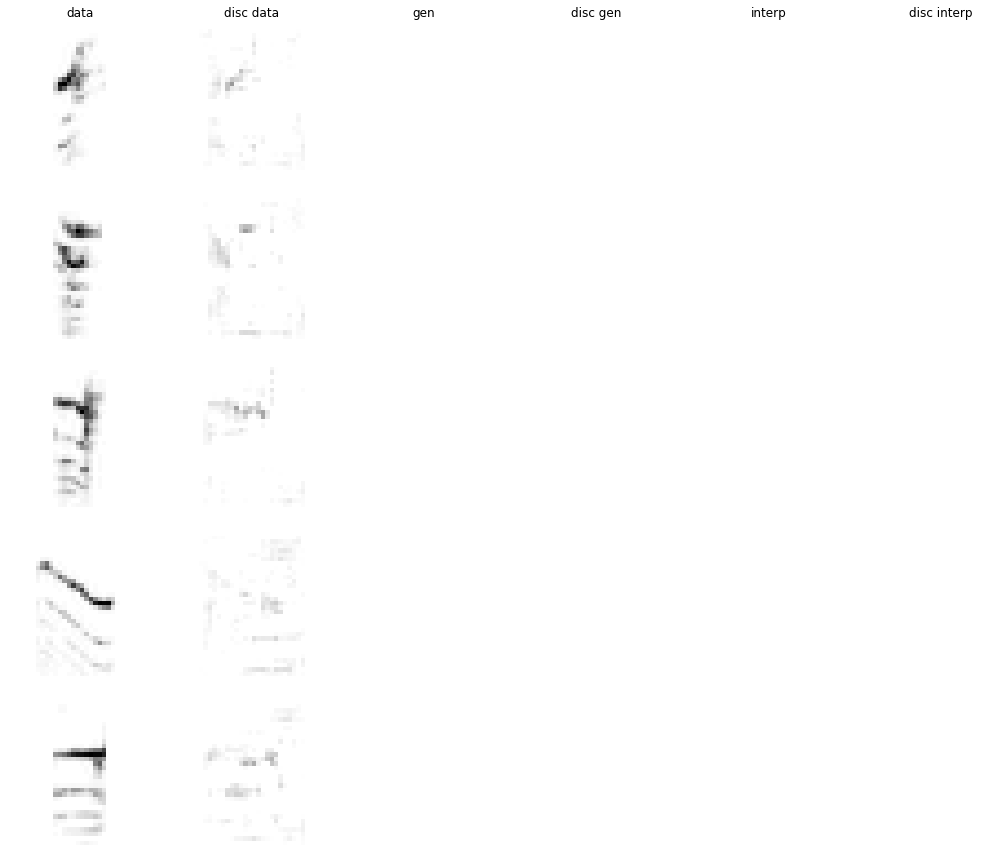

In [22]:
plot_reconstruction(model, example_data)

In [23]:
def plot_losses(losses):
    cols = list(losses.columns)
    fig, axs = plt.subplots(ncols = len(cols), figsize= (len(cols)*4, 4))
    for ci, col in enumerate(cols):
        if len(cols) == 1:
            ax = axs
        else:
            ax = axs.flatten()[ci]
        ax.plot(losses[col].values)
        ax.set_title(col)
    plt.show()

In [24]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(
    columns=[
        "X_D_G_X_loss",
        "X_D_G_Zi_loss",
        "X_G_loss",
        "X_D_X_loss",
        "G_loss",
        "D_loss",
    ]
)

In [25]:
N_TRAIN_BATCHES = 50

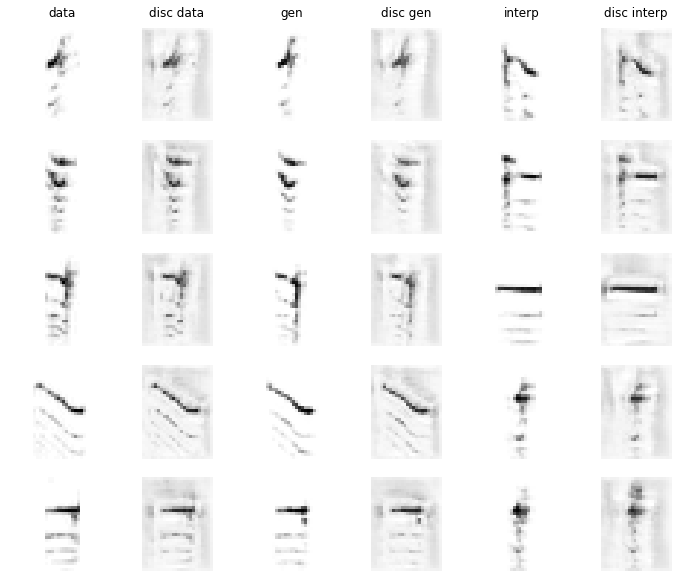

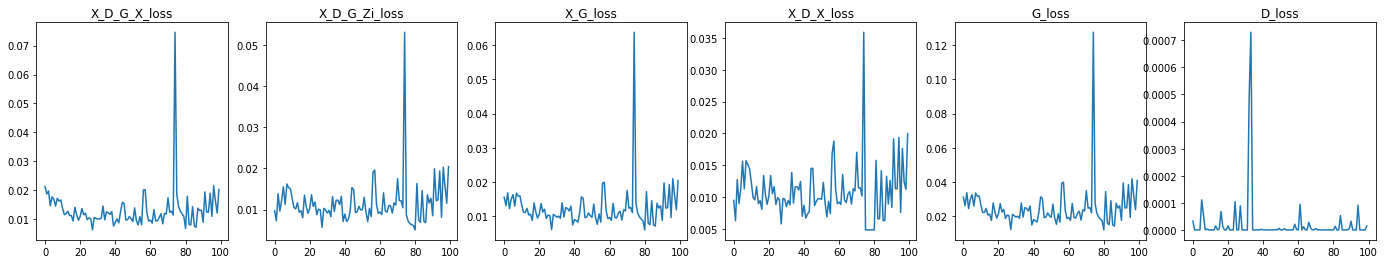

In [26]:
n_epochs = 100
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        #print(train_x[-1].numpy()[:4])
        x = tf.cast(tf.reshape(train_x[0], [BATCH_SIZE] + list(DIMS)), tf.float32) / 255
        model.train_net(x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        x = tf.cast(tf.reshape(test_x[0], [BATCH_SIZE] + list(DIMS)), tf.float32) / 255
        loss.append(model.compute_loss(x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    display.clear_output()
    plot_reconstruction(model, example_data, zm = 2)
    # 
    plot_losses(losses)

In [27]:
z, xg, zi, xi, d_xi, d_x, d_xg = model.network_pass(example_data)

In [28]:
0.006295

0.006295

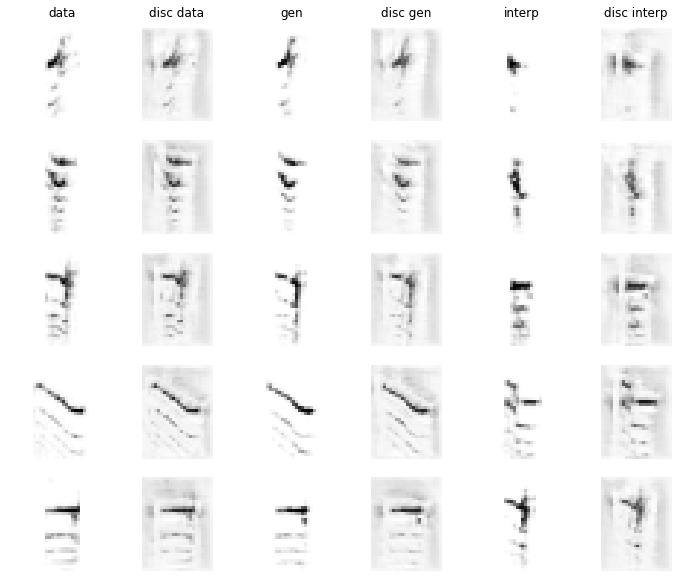

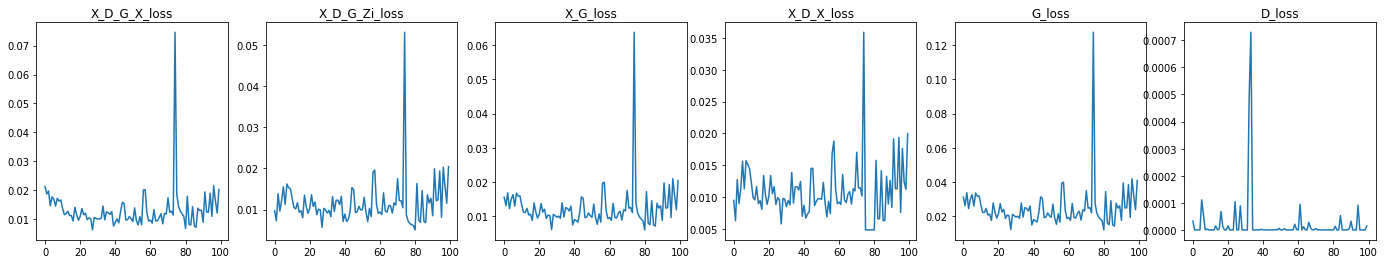

In [29]:
plot_reconstruction(model, example_data, zm = 2)
# 
plot_losses(losses)

In [30]:
losses

,X_D_G_X_loss,X_D_G_Zi_loss,X_G_loss,X_D_X_loss,G_loss,D_loss
0,0.021338,0.009699,0.015518,0.009478,0.031037,0.000033
1,0.018763,0.007279,0.013021,0.006289,0.026042,0.000000
2,0.019770,0.013851,0.016811,0.012738,0.033621,0.000000
3,0.014666,0.009640,0.012153,0.009002,0.024306,0.000000
4,0.017745,0.012240,0.014992,0.011300,0.029985,0.000000
5,0.016980,0.015533,0.016256,0.015619,0.032513,0.000111
6,0.014570,0.011260,0.012915,0.011291,0.025830,0.000056
7,0.017240,0.016216,0.016728,0.015725,0.033456,0.000000
8,0.016319,0.015334,0.015827,0.015122,0.031653,0.000003
9,0.016675,0.015083,0.015879,0.014462,0.031757,0.000000


In [31]:
(losses.X_D_X_loss.values - losses.X_D_G_Zi_loss.values) / losses.X_D_G_Zi_loss.values

array([-0.02280932, -0.13600194, -0.08035886, -0.06615396, -0.07677799,
        0.00552657,  0.00272781, -0.0303354 , -0.01385788, -0.04117405,
       -0.03097204, -0.05997417, -0.05637599, -0.00136397, -0.0404433 ,
       -0.03015845,  0.00751818, -0.00889003, -0.03341661, -0.02548956,
       -0.00765642, -0.01672349, -0.02017799, -0.01940141,  0.01196261,
       -0.01760302, -0.03458624,  0.01539388, -0.0495596 , -0.02327378,
       -0.07270035, -0.03361358,  0.05852791,  0.05548995, -0.05048518,
       -0.05042326, -0.05416917, -0.01051256, -0.05708543, -0.01317514,
       -0.0229715 , -0.06164649, -0.03672124, -0.19473994, -0.05446402,
       -0.02296653, -0.06556948, -0.0098438 , -0.09590014, -0.01490822,
       -0.03106988, -0.05257704, -0.03003844, -0.02599156, -0.0911986 ,
       -0.10622462, -0.11351487, -0.04060661, -0.00359038, -0.0146094 ,
       -0.02201546,  0.00983938, -0.03710299, -0.0200722 , -0.01976547,
       -0.05018801, -0.0051722 , -0.02733033, -0.02643007, -0.01

In [32]:
losses.D_prop_gen.values

AttributeError: 'DataFrame' object has no attribute 'D_prop_gen'

In [ ]:
plot_reconstruction(model, example_data)

In [ ]:
losses.d_xg_loss.values

In [ ]:
#save_loc = DATA_DIR / 'models' / network_type / DATASET_ID
#ensure_dir(save_loc)

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model shuold be saved to HDF5.
#model.save_weights((save_loc / (str(epoch).zfill(4))).as_posix()) 

# Recreate the exact same model, including its weights and the optimizer
#new_model = tf.keras.models.load_model('my_model.h5')

### Plot samples from latent

In [ ]:
z = model.encode(example_data).numpy()

In [ ]:
xmax, ymax = np.max(z, axis=0)
xmin, ymin = np.min(z, axis=0)
print(xmax, ymax, xmin, ymin)

In [ ]:
# sample from grid
nx = ny= 30
meshgrid = np.meshgrid(np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny))
meshgrid = np.array(meshgrid).reshape(2, nx*ny).T
x_grid = model.decode(meshgrid)
x_grid = x_grid.numpy().reshape(nx, ny, DIMS[0], DIMS[1], DIMS[2])
# fill canvas
canvas = np.zeros((nx*DIMS[0], ny*DIMS[1]))
for xi in range(nx):
    for yi in range(ny):
        canvas[xi*DIMS[0]:xi*DIMS[0]+DIMS[0], yi*DIMS[1]:yi*DIMS[1]+DIMS[1]] = x_grid[xi, yi,:,:,:].squeeze()
fig, ax = plt.subplots(figsize=(15,10))
ax.matshow(canvas, vmin = 0, cmap=plt.cm.Greys, origin = 'lower')
ax.axis('off')

###  plot dataset 

In [ ]:
all_x = []
all_z = []
all_indv = []
all_labels = []
for batch, train_x in tqdm(
    zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
):
    x = train_x[0]
    all_x.append(x)
    x = tf.cast(tf.reshape(x, [BATCH_SIZE] + list(DIMS)), tf.float32) / 255
    #model.train_net(x)
    all_z.append(model.encode(x).numpy())
    all_indv.append(train_x[3].numpy())
    all_labels.append(train_x[2].numpy())

all_z = np.vstack(all_z)
all_indv = np.concatenate(all_indv)
all_labels = np.concatenate(all_labels)
all_x = np.concatenate(all_x)
all_x = np.reshape(all_x, [len(all_x)] + list(DIMS[:2]))

In [ ]:
from avgn.visualization.projections import scatter_spec

In [ ]:
np.shape(all_z)

In [ ]:
plt.scatter(all_z[:,0], all_z[:,1], s=1, c='k', alpha=0.1)

In [ ]:
scatter_spec(
        np.vstack(all_z),
        all_x,
        column_size=15,
        x_range = [-4,4],
        y_range = [-4,4],
        pal_color="hls",
        color_points=False,
        enlarge_points=20,
        figsize=(10, 10),
        scatter_kwargs = {
            'labels': list(all_labels),
            'alpha':0.25,
            's': 1,
            'show_legend': False
        },
        matshow_kwargs = {
            'cmap': plt.cm.Greys
        },
        line_kwargs = {
            'lw':1,
            'ls':"solid",
            'alpha':0.25,
        },
        draw_lines=True
);